In [1]:
using SpecialFunctions, Plots, ProgressMeter, LaTeXStrings, Polynomials, DataFrames, CSV, LinearAlgebra

## Definitions

We use the definition
$$S_{h,j} = \left[ \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right] \frac{1}{(2h_\phi - h + j) (2h_\phi + h - 1 + j)}$$
where the term in square bracket may or may not be included, depending on what needs to be computed:
- Without this term, $S_{h, j}$ is particularly simple to evaluate. It is however singular at $h = 2h_\phi + j$, as well as at $h = 1 - 2 h_\phi$ when $j = 0$.
- With the square bracket term, $S_{h,j}$ is regular at any value of $h > 0$, and it has zeros at $h = 2h_\phi + n$ with integer $n$. It corresponds to the expression given in paper without the factor $\Gamma(2h)/\Gamma(h)^2$, and can be rewritten
$$S_{h,j} =  \frac{(2h_\phi - h)_j (2h_\phi + h - 1)_j}{\Gamma(2h_\phi - h + j + 1) \Gamma(2h_\phi + h + j)}$$

In [2]:
gammainverse(x :: Real) = x <= 0.0 && isinteger(x) ? 0.0 : 1.0 / gamma(x)

gammainverse (generic function with 1 method)

In [3]:
S(twohϕ :: Float64, h :: Float64, j :: Int; singular_normalization=false) = (
    singular_normalization ? 1.0 / ((twohϕ - h + j) * (h + twohϕ - 1 + j))
    : (j == 0 ? 1 : prod((twohϕ - h + i) * (twohϕ + h - 1 + i) for i = 0:j-1))
        * gammainverse(twohϕ - h + j + 1) * gammainverse(twohϕ + h + j))

S (generic function with 1 method)

With the same normalization, we have 
$$T_{h,j} = \left[ \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h)^2 \Gamma(2h_\phi - 1 + h) \Gamma(1 - 2h_\phi + h)}
{\Gamma(2h) \Gamma(2h_\phi + h + j) \Gamma(1 - 2h_\phi + h -j)}
{}_4F_3\left( \begin{array}{c}
    h,h, 2h_\phi - 1 + h, 1 - 2h_\phi + h \\ 2h, 2h_\phi + h + j, 1 - 2h_\phi + h - j
\end{array}; 1\right)$$

This can be written as an infinite sum
$$T_{h,j} = \sum_{k = 0}^\infty T_{h,j,k}$$
with
$$T_{h,j,k} = \left[ \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h + k)^2 \Gamma(2h_\phi - 1 + h + k) \Gamma(1 - 2h_\phi + h + k)}
{k! \Gamma(2h + k) \Gamma(2h_\phi + h + j + k) \Gamma(1 - 2h_\phi + h - j + k)}$$

At large values of $k$, we have
$$T_{h,j,k} \sim \left[ \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{1}{k^2} \qquad (k \to \infty)$$
and the sum is therefore absolutely convergent.

The $T_{h,j,k}$ obey a simple recursion relation in $j$,
$$T_{h,j+1,k} = \frac{h - 2 h_\phi - j + k}{h + 2 h_\phi + j + k} T_{h,j,k}$$
with the initial term
$$T_{h,0,k} = \left[ \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right]
\frac{\Gamma(h + k)^2}{k! \Gamma(2h + k) (2h_\phi + h + k - 1)}$$

Then, for the term with $j = 0$ and integer-spaced values of $h$, there is the recursion relation in $h$
$$T_{h+1,0,k} = \left[ \frac{2 h_\phi - h - 1}{2 h_\phi + h - 1} \right] \frac{(h + k)^2 (h + 2h_\phi + k - 1)}
{(2h + k + 1) (2h + k) (2 h_\phi + h + k)} T_{h, 0, k}$$

Finally, there is a recursion relation in $k$,
$$T_{h, 0, k+1} = \frac{(h+k)^2 (2 h_\phi + h + k - 1)}{(k + 1)(2h + k)(2h_\phi + h + k)} T_{h, 0, k}$$
starting at
$$T_{h, 0, 0} = \left[ \frac{1}{\Gamma(2h_\phi - h) \Gamma(2h_\phi + h - 1)} \right] \frac{\Gamma(h)^2}{\Gamma(2h) (2h_\phi + h - 1)}$$

There is a special case when $h = 1 - 2 h_\phi$. With the term in square bracket, only the term $k = 0$ is present in the sum, and we have
$$T_{h, j} = \frac{\Gamma(h)^2}{j! \Gamma(2h -j) \Gamma(1 - 2h)}$$
Without the square bracket normalization, $T_{h, j}$ is singular at all $j$, unless $h = 2h_\phi = \frac{1}{2}$, in which case the terms with $j > 0$ are regular again and given by
$$T_{h, j} = \sum_{k=0}^{j-1} \frac{(-1)^{j+k+1} \sqrt{\pi} (j-1)!}{k! \left(k + \frac{1}{2} \right) \Gamma\left( j - k + \frac{1}{2} \right)}
\qquad \left( h = 2h_\phi = \tfrac{1}{2}, ~ j > 0 \right)$$

In [4]:
Thalf(j :: Int) = (j > 0 ? sum(gamma(j) * sqrt(π) * (-1)^(j+k+1) / gamma(k + 1) / (k + 1/2) / gamma(j - k + 0.5) for k=0:j-1)
    : NaN)

Thalf (generic function with 1 method)

In [5]:
[Thalf(j) for j = 0:50]

51-element Vector{Float64}:
 NaN
   3.9999999999999996
  -1.3333333333333335
   1.155555555555556
  -0.7238095238095241
   0.6679365079365076
  -0.4960076960076962
   0.46910549767692555
  -0.37713397713397834
   0.3613739927465408
  -0.30418396189293717
   0.2938468917641446
  -0.2548668971606277
   ⋮
   0.08121107393951131
  -0.07791453031163337
   0.07721811297985459
  -0.07423332783259501
   0.07360120270363452
  -0.07088764552389265
   0.07030630886048395
  -0.06780627732412532
   0.06730547882536689
  -0.06502072232063619
   0.06471592812680274
  -0.06211983876032327

## Matrices of $S_{h,j} - T_{h,j}$

The following functions define $n_j \times n_h$ matrices whose entries are respectively given by $S_{h,j}$ and $T_{h,j}$, with $j = 0, 1, 2, \ldots, n_j-1$ and $h = h_0, h_0 + 1, \ldots, h_0 + n_h - 1$:

In [6]:
S_matrix(twohϕ :: Float64, h0 :: Float64, nj :: Int, nh :: Int = nj; singular_normalization=false) = (
    [S(twohϕ, h0 + i, j, singular_normalization=singular_normalization) for i = 0:nh-1, j = 0:nj-1])

S_matrix (generic function with 2 methods)

In [7]:
function T_matrix(twohϕ :: Float64, h0 :: Float64, nj :: Int, nh :: Int = nj; singular_normalization=false, kmax :: Int = 1000000)
    
    twohϕ > 0 || throw(DomainError(hϕ, "hϕ must be strictly positive"))
    h0 > 0 || throw(DomainError(h0, "h must be strictly positive"))

    if twohϕ + h0 == 1.0
        Th0 = [(singular_normalization ? (h0 == 0.5 ? Thalf(j) : NaN)
                : gamma(h0)^2 / gamma(j + 1) * gammainverse(2*h0 - j) * gammainverse(1 - 2*h0)) for j = 0:nj-1]
        Th = T_matrix(twohϕ, h0 + 1.0, nj, nh - 1, singular_normalization=singular_normalization)
        return vcat(hcat(Th0)', Th)
    end
    
    Th00 = gamma(h0)^2 / gamma(2 * h0) * (singular_normalization ? 1.0 / (twohϕ + h0 - 1)
        : gammainverse(twohϕ - h0) * gammainverse(twohϕ + h0)) 
    Th0k = [Th00]
    for k = 0:kmax-1
        Th00 *= (h0 + k)^2 * (twohϕ + h0 + k - 1.) / (k + 1) / (2*h0 + k) / (twohϕ + h0 + k)
        push!(Th0k, Th00)
    end

    k = collect(0:kmax)
    Thjk = [copy(Th0k)]
    for i = 0:nh-2
        h = h0 + i
        hk = h .+ k
        Th0k .*= hk.^2 .* (hk .+ (twohϕ - 1.)) ./ (2*h .+ k) ./ ((2*h + 1.) .+ k) ./ (hk .+ twohϕ)
        if singular_normalization == false
            Th0k .*= (twohϕ - h - 1) / (twohϕ + h - 1)
        end
        push!(Thjk, copy(Th0k))
    end
    Thjk = reduce(hcat, Thjk)'

    result = [sum(Thjk, dims=2)]
    h = h0 .+ collect(0:nh-1)
    hk = h .+ k'
    for j = 0:nj-2
        Thjk .*= (hk .- (j + twohϕ)) ./ ((j + twohϕ) .+ hk)
        push!(result, sum(Thjk, dims=2))
    end

    return reduce(hcat, result)
end

T_matrix (generic function with 2 methods)

**Performance tests**

Choosing a very large value of $k_\text{max}$ does not impact the computation speed very much:

In [8]:
@time T_matrix(0.5, 1.0, 10, kmax=1000)

  0.072398 seconds (224.61 k allocations: 11.943 MiB, 99.52% compilation time)


10×10 Matrix{Float64}:
 -0.441112   -0.19519    -0.0166994  -0.0254251  …  -0.00107297  -0.00278127
  0.194873    0.151246    0.0798302   0.0418047      0.00673312   0.0052601
 -0.12217    -0.108276   -0.0786496  -0.0522816     -0.0105468   -0.00834848
  0.0881425   0.0822176   0.0679081   0.0519506      0.0135455    0.0108845
 -0.0684988  -0.0654848  -0.0576904  -0.0478585     -0.0156575   -0.0128008
  0.0557001   0.0539753   0.0493274   0.0430081  …   0.0169507    0.0141099
 -0.0466771  -0.0456039  -0.0426342  -0.0383944     -0.0175657   -0.0148809
  0.0399534   0.0392427   0.0372405   0.0342848      0.017662     0.0152098
 -0.0347333  -0.0342396  -0.0328308  -0.0307009     -0.0173863   -0.0151963
  0.0305509   0.0301946   0.0291685   0.0275898      0.016858     0.0149302

In [9]:
@time T_matrix(0.5, 1.0, 10, kmax=10000)

  0.001474 seconds (155 allocations: 3.378 MiB)


10×10 Matrix{Float64}:
 -0.441255   -0.195333   -0.0168421  -0.0255674  …  -0.00121109  -0.00291811
  0.195301    0.151674    0.0802574   0.0422307      0.00714659   0.00566976
 -0.122882   -0.108986   -0.0793594  -0.0529894     -0.0112337   -0.00902906
  0.089134    0.0832086   0.0688974   0.0529372      0.014503     0.0118332
 -0.0697666  -0.066752   -0.0589555  -0.0491201     -0.0168819   -0.0140141
  0.0572396   0.055514    0.0508635   0.0445401  …   0.0184377    0.0155832
 -0.0484827  -0.0474085  -0.0444358  -0.0401912     -0.0193098   -0.0166091
  0.0420188   0.041307    0.0393014   0.0363401      0.0196573    0.0171869
 -0.0370515  -0.0365564  -0.0351439  -0.0330078     -0.0196259   -0.0174156
  0.033114    0.0327563   0.0317261   0.0301405      0.0193345    0.0173844

In [10]:
@time T_matrix(0.5, 1.0, 10, kmax=100000)

  0.024974 seconds (159 allocations: 32.353 MiB, 5.17% gc time)


10×10 Matrix{Float64}:
 -0.44127    -0.195347   -0.0168564  -0.0255817  …  -0.00122536  -0.00293237
  0.195344    0.151717    0.0803004   0.0422737      0.00718939   0.00571253
 -0.122953   -0.109058   -0.0794309  -0.053061      -0.011305    -0.00910031
  0.0892341   0.0833087   0.0689975   0.0530373      0.0146028    0.0119329
 -0.0698953  -0.0668806  -0.0590841  -0.0492488     -0.0170102   -0.0141422
  0.0573968   0.0556711   0.0510207   0.0446972  …   0.0185943    0.0157397
 -0.0486683  -0.0475941  -0.0446214  -0.0403768     -0.0194947   -0.0167939
  0.0422328   0.041521    0.0395154   0.036554       0.0198705    0.0174
 -0.0372938  -0.0367987  -0.0353862  -0.0332499     -0.0198673   -0.0176568
  0.0333845   0.0330268   0.0319966   0.0304109      0.0196041    0.0176537

In [11]:
@time T_matrix(0.5, 1.0, 10)

  0.567352 seconds (165 allocations: 322.595 MiB, 44.47% gc time)


10×10 Matrix{Float64}:
 -0.441271   -0.195348   -0.0168579  -0.0255831  …  -0.00122679  -0.0029338
  0.195348    0.151722    0.0803047   0.042278       0.00719369   0.00571682
 -0.122961   -0.109065   -0.0794381  -0.0530681     -0.0113121   -0.00910747
  0.0892442   0.0833187   0.0690076   0.0530473      0.0146128    0.011943
 -0.0699082  -0.0668935  -0.059097   -0.0492616     -0.0170231   -0.0141551
  0.0574125   0.0556869   0.0510364   0.0447129  …   0.01861      0.0157554
 -0.0486869  -0.0476127  -0.04464    -0.0403954     -0.0195134   -0.0168125
  0.0422543   0.0415425   0.0395369   0.0365755      0.019892     0.0174214
 -0.0373181  -0.0368231  -0.0354105  -0.0332743     -0.0198917   -0.0176812
  0.0334117   0.033054    0.0320238   0.0304381      0.0196313    0.0176809

However, the computation time increases significantly with $n$:

In [12]:
@time T_matrix(0.5, 1.0, 20);

  1.540649 seconds (286 allocations: 627.780 MiB, 39.09% gc time)


In [13]:
@time T_matrix(0.5, 1.0, 50);

  6.807375 seconds (648 allocations: 1.507 GiB, 7.56% gc time)


In [14]:
@time T_matrix(0.5, 1.0, 100);

 27.716131 seconds (1.25 k allocations: 2.997 GiB, 2.79% gc time)


The computation time is independent of the choice of parameters:

In [15]:
@time T_matrix(1.0, 1.2, 100);

 29.036134 seconds (1.25 k allocations: 2.997 GiB, 2.63% gc time)


## Asymptotics

$S$ and $T$ have identical asymptotics at large $j$, for any fixed $h$,
$$\lim_{j \to \infty} \frac{T_{h,j}}{S_{h,j}} = +1$$
but opposite asymptotics at large $h$, for any fixed $j$:
$$\lim_{h \to \infty} \frac{T_{h,j}}{S_{h,j}} = -1$$


In [16]:
TS_ratio = T_matrix(0.5, 1.0, 20) ./ S_matrix(0.5, 1.0, 20);

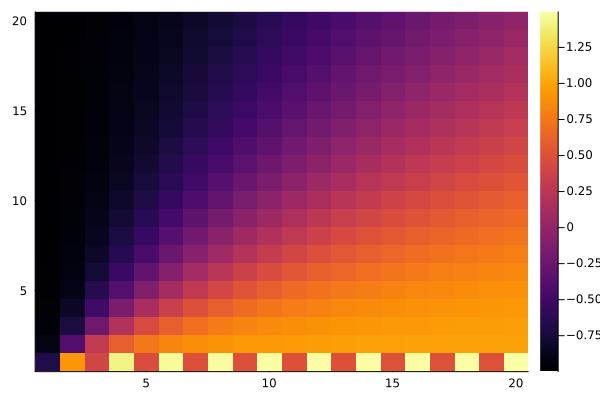

In [17]:
heatmap(TS_ratio)

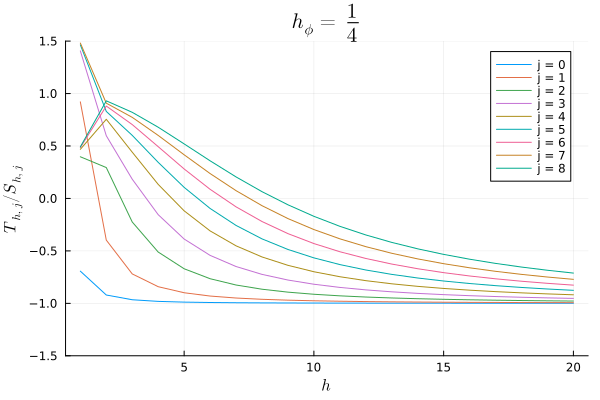

In [18]:
plot()
for j = 0:8
    plot!(TS_ratio[:,j+1], label="j = $j")
end
xlabel!(L"h")
ylims!(-1.5, 1.5)
ylabel!(L"T_{h,j} / S_{h,j}")
title!(L"h_\phi = \frac{1}{4}")

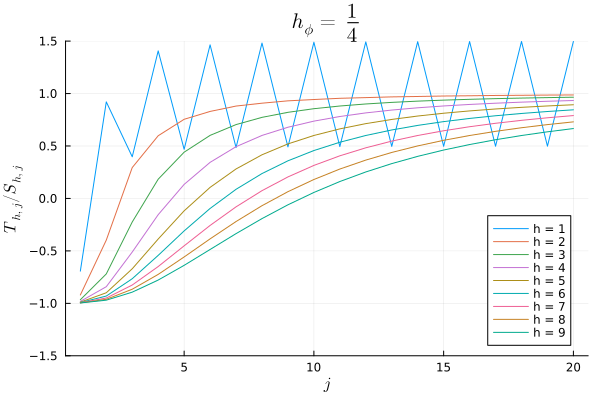

In [19]:
plot()
for h = 1:9
    plot!(TS_ratio[h,:], label="h = $h")
end
xlabel!(L"j")
ylims!(-1.5, 1.5)
ylabel!(L"T_{h,j} / S_{h,j}")
title!(L"h_\phi = \frac{1}{4}")

We define $G$ as the difference between $S$ and $T$
$$G_{h,j} = S_{h,j} - T_{h,j}$$

In [20]:
G_matrix(twohϕ :: Float64, h0 :: Float64, nj :: Int, nh :: Int = nj; singular_normalization=false, kmax :: Int = 1000000) = (
    S_matrix(twohϕ, h0, nj, nh, singular_normalization=singular_normalization)
    - T_matrix(twohϕ, h0, nj, nh, singular_normalization=singular_normalization, kmax=kmax))

G_matrix (generic function with 2 methods)

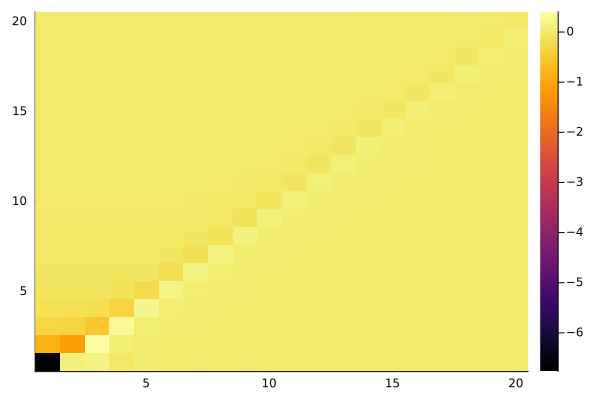

In [21]:
heatmap(G_matrix(0.5, 1.0, 20, singular_normalization=true))

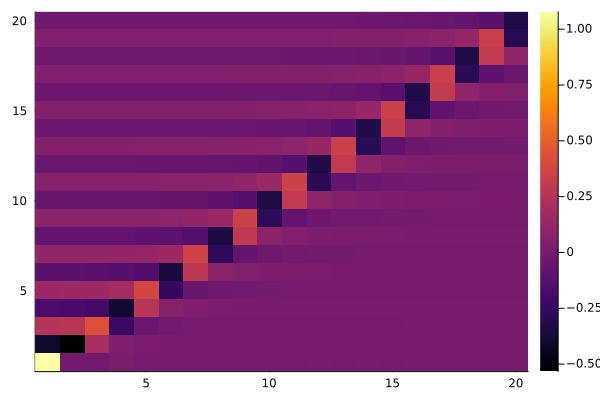

In [22]:
heatmap(G_matrix(0.5, 1.0, 20))

## Tables of values

In [24]:
hϕ_table = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

6-element Vector{Float64}:
 0.1
 0.2
 0.25
 0.3
 0.4
 0.5

In [25]:
jmax = 50
hmax = 10

Δh = 0.01

h0_table = collect(Δh : Δh : 1)
length(h0_table)

100

In [26]:
# for hϕ ∈ hϕ_table
#     println("hϕ = $(hϕ)")
#     df = reduce(vcat, @showprogress [reduce(hcat, [DataFrame("h" => [h0 + i for i = 0:hmax-1]),
#             DataFrame(G_matrix(2*hϕ, h0, jmax + 1, hmax), string.(0:jmax))])
#             for h0 ∈ h0_table])
#     sort!(df, "h")
#     CSV.write("data/G-$(hϕ).csv", df)
# end

## Plots of $S_{h,j} - T_{h,j}$

In [29]:
G_df = CSV.read("data/G_0.25.csv", DataFrame, select=["h", "0", "1", "2", "3"])

Row,h,0,1,2,3
,Float64,Float64,Float64,Float64,Float64
1,0.01,-62.5454,61.1106,-60.34,59.8421
2,0.02,-30.6762,29.2929,-28.5575,28.0881
3,0.03,-20.0281,18.6972,-17.9963,17.5544
4,0.04,-14.6856,13.4078,-12.7408,12.3253
5,0.05,-11.4657,10.2416,-9.60775,9.21771
6,0.06,-9.30727,8.13755,-7.53609,7.17046
7,0.07,-7.75568,6.64084,-6.07098,5.72873
8,0.08,-6.58355,5.52405,-4.98496,4.6651
9,0.09,-5.66457,4.66081,-4.15165,3.85318


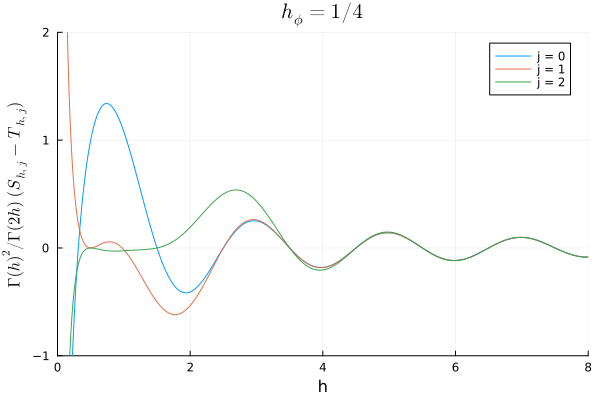

In [30]:
plot()
for j = 0:2
    plot!(G_df[!, "h"], G_df[!, string(j)], label="j = $j")
end
xlims!(0, 8)
ylims!(-1, 2)
xlabel!("h")
ylabel!(L"\Gamma(h)^2 / \Gamma(2h) ~ ( S_{h,j} - T_{h,j} )")
title!(L"h_\phi = 1/4")

## β functionals: zeros at double-trace dimensions $h = 2h_\phi + 2n (+1)$

In [43]:
function βFcoefficients(twohϕ :: Float64, n :: Int)
    halfn = (n+1) ÷ 2
    coeffs = zeros(n, halfn)
    G = G_matrix(twohϕ, twohϕ + 1, 2*n - 1, singular_normalization=true)[1:2:n, 1:2:n]
    coeffs[1:2:n, 1:halfn] = inv(G)
    return coeffs
end

βFcoefficients (generic function with 1 method)

In [32]:
# βFcoeffs = Dict{String, Vector{Float64}}()
# βF = Dict{String, Vector{Float64}}()
# @showprogress for hϕ ∈ hϕ_table
#     c = βFcoefficients(2 * hϕ, jmax+1)
#     βFcoeffs[string(hϕ)] = c[:, 1]
#     G_df = CSV.read("data/G_$(hϕ).csv", DataFrame)
#     h = G_df[!, "h"]
#     Γ_factor = gamma.(2*h) ./ gamma.(h).^2
#     if "h" ∉ keys(βF)
#         βF["h"] = h
#     end
#     βF[string(hϕ)] = Diagonal(Γ_factor) * Matrix(G_df[!, [string(j) for j = 0:jmax]]) * c[:, 1]
# end
# CSV.write("data/beta_F_coeffs.csv", DataFrame(βFcoeffs))
# CSV.write("data/beta_F.csv", DataFrame(βF));

In [33]:
βF_coeffs = CSV.read("data/beta_F_coeffs.csv", DataFrame)

Row,0.1,0.2,0.25,0.3,0.4,0.5
,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.200691,-0.404398,-0.507741,-0.612123,-0.823952,-1.03964
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.173917,0.340186,0.421409,0.50166,0.659817,0.815489
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0171072,0.0397952,0.0527427,0.0665635,0.0963718,0.128476
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00477654,0.0117673,0.0159954,0.0206644,0.0311967,0.0431297
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00195494,0.00495429,0.0068225,0.00892321,0.0137819,0.019451


In [34]:
βF = CSV.read("data/beta_F.csv", DataFrame)

Row,0.1,0.2,0.25,0.3,0.4,0.5,h
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00060365,0.00354218,0.00626134,0.00987815,0.0194881,0.0310108,0.01
2,0.00107111,0.00665087,0.0118557,0.0187865,0.0371695,0.0590822,0.02
3,0.00141169,0.00940725,0.0169585,0.0270553,0.0539222,0.0859927,0.03
4,0.00162822,0.0118174,0.021577,0.0346933,0.0697568,0.111754,0.04
5,0.00172352,0.0138872,0.0257188,0.0417093,0.0846839,0.136377,0.05
6,0.00170036,0.0156226,0.0293912,0.0481118,0.0987139,0.159873,0.06
7,0.00156152,0.0170296,0.0326014,0.0539094,0.111857,0.182254,0.07
8,0.00130976,0.0181139,0.0353569,0.0591105,0.124124,0.20353,0.08
9,0.000947807,0.0188815,0.0376647,0.0637235,0.135523,0.223712,0.09


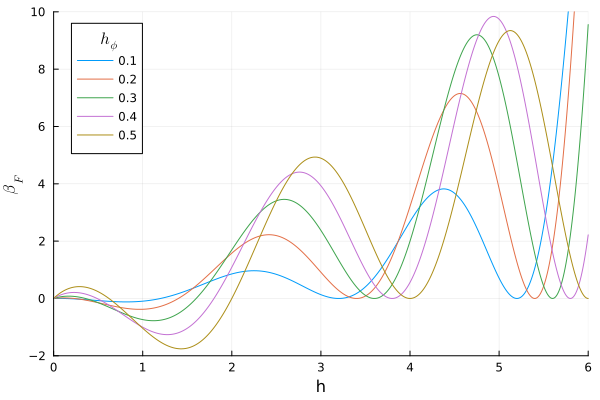

In [35]:
plot(legendtitle = L"h_\phi")
for hϕ = 0.1:0.1:0.5
    plot!(βF[!, "h"], βF[!, string(hϕ)], label=hϕ)
end
xlims!(0,6)
ylims!(-2,10)
xlabel!("h")
ylabel!(L"\beta_F")

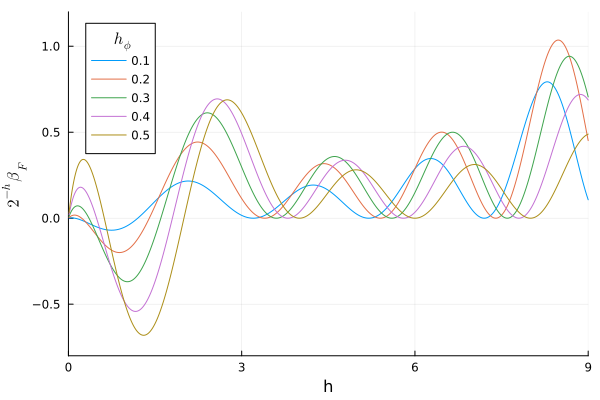

In [36]:
plot(legendtitle = L"h_\phi")
for hϕ = 0.1:0.1:0.5
    plot!(βF[!, "h"], 0.5.^βF[!, "h"] .* βF[!, string(hϕ)], label=hϕ)
end
xlims!(0,9)
ylims!(-0.8, 1.2)
xlabel!("h")
ylabel!(L"2^{-h} \beta_F")

In [46]:
function βBcoefficients(twohϕ :: Float64, n :: Int)
    halfn = n ÷ 2
    coeffs = zeros(n, halfn)
    G = G_matrix(twohϕ, twohϕ + 1, 2*n - 1, singular_normalization=true)[2:2:n, 2:2:n]
    coeffs[2:2:n, 1:halfn] = inv(G)
    return coeffs
end

βBcoefficients (generic function with 1 method)

In [38]:
# βBcoeffs = Dict{String, Vector{Float64}}()
# βB = Dict{String, Vector{Float64}}()
# @showprogress for hϕ ∈ hϕ_table
#     c = βBcoefficients(2 * hϕ, jmax+1)
#     βBcoeffs[string(hϕ)] = c[:, 1]
#     G_df = CSV.read("data/G_$(hϕ).csv", DataFrame)
#     h = G_df[!, "h"]
#     Γ_factor = gamma.(2*h) ./ gamma.(h).^2
#     if "h" ∉ keys(βB)
#         βB["h"] = h
#     end
#     βB[string(hϕ)] = Diagonal(Γ_factor) * Matrix(G_df[!, [string(j) for j = 0:jmax]]) * c[:, 1]
# end
# CSV.write("data/beta_B_coeffs.csv", DataFrame(βBcoeffs))
# CSV.write("data/beta_B.csv", DataFrame(βB));

In [39]:
βB_coeffs = CSV.read("data/beta_B_coeffs.csv", DataFrame)

Row,0.1,0.2,0.25,0.3,0.4,0.5
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.19509,-1.46302,-1.59337,-1.72201,-1.97552,-2.22557
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.928005,1.11026,1.19669,1.28076,1.44338,1.60042
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.150647,0.193974,0.215532,0.237007,0.279691,0.322004
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0516688,0.0689406,0.0778343,0.0868723,0.105315,0.124154
9,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
βB = CSV.read("data/beta_B.csv", DataFrame)

Row,0.1,0.2,0.25,0.3,0.4,0.5,h
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.00156102,-0.00794656,-0.0132399,-0.0198085,-0.0356743,-0.0526488,0.01
2,-0.00267038,-0.0142519,-0.0238862,-0.0358115,-0.0643917,-0.0945049,0.02
3,-0.00348026,-0.0196952,-0.0333341,-0.0502663,-0.090896,-0.133635,0.03
4,-0.0040254,-0.0243337,-0.0416514,-0.0632505,-0.11528,-0.170138,0.04
5,-0.00433918,-0.0282223,-0.0489037,-0.0748393,-0.137632,-0.204112,0.05
6,-0.00445362,-0.0314144,-0.0551548,-0.0851058,-0.158042,-0.235649,0.06
7,-0.00439946,-0.0339616,-0.0604664,-0.0941213,-0.176593,-0.264843,0.07
8,-0.00420608,-0.0359137,-0.0648984,-0.101955,-0.193369,-0.291783,0.08
9,-0.0039016,-0.0373188,-0.0685088,-0.108673,-0.208451,-0.316557,0.09


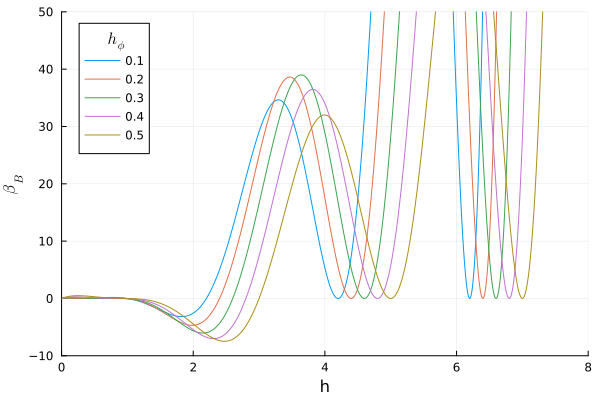

In [41]:
plot(legendtitle = L"h_\phi")
for hϕ = 0.1:0.1:0.5
    plot!(βB[!, "h"], -1 .* βB[!, string(hϕ)], label=hϕ)
end
xlims!(0,8)
ylims!(-10,50)
xlabel!("h")
ylabel!(L"\beta_B")

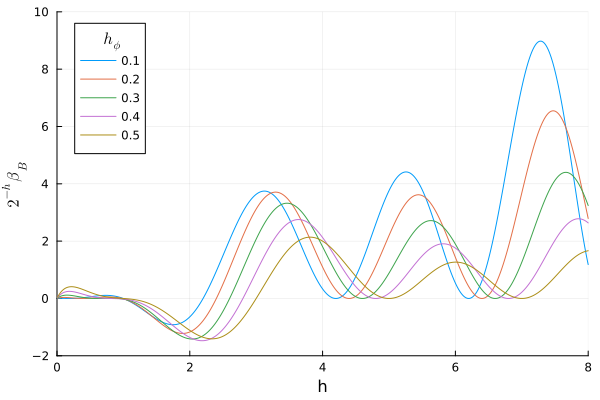

In [42]:
plot(legendtitle = L"h_\phi")
for hϕ = 0.1:0.1:0.5
    plot!(βB[!, "h"], -1 .* 0.5.^βB[!, "h"] .* βB[!, string(hϕ)], label=hϕ)
end
xlims!(0,8)
ylims!(-2, 10)
xlabel!("h")
ylabel!(L"2^{-h} \beta_B")

## γ functionals: zeros at integer dimensions

In [51]:
γcoefficients(twohϕ :: Float64, n :: Int) = inv(G_matrix(twohϕ, 1.0, n, singular_normalization=true))

γcoefficients (generic function with 1 method)

In [77]:
# @showprogress for hϕ ∈ hϕ_table
#     γcoeffs = γcoefficients(2 * hϕ, jmax + 1)[:, 1:hmax]
#     CSV.write("data/gamma_coeffs_$(hϕ).csv", DataFrame(γcoeffs, string.(1:hmax)))
#     G_df = CSV.read("data/G_$(hϕ).csv", DataFrame)
#     h = G_df[!, "h"]
#     Γ_factor = gamma.(2*h) ./ gamma.(h).^2
#     γ = Diagonal(Γ_factor) * Matrix(G_df[!, [string(j) for j = 0:jmax]]) * γcoeffs
#     γ_df = DataFrame(γ, string.(1:hmax))
#     γ_df[!, "h"] = h
#     CSV.write("data/gamma_$(hϕ).csv", γ_df)
# end

In [78]:
γ_coeffs = CSV.read("data/gamma_coeffs_0.25.csv", DataFrame)

Row,1,2,3,4,5,6,7,8,9,10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.145451,-1.2553e-8,-0.0363627,-1.53773e-7,-0.0204543,-5.93367e-7,-0.0142051,-1.50218e-6,-0.0108772,-3.05209e-6
2,0.117401,-0.710651,-0.317001,-0.244267,-0.172104,-0.154647,-0.119178,-0.113413,-0.0912282,-0.0895888
3,0.0166183,0.491717,-1.10233,-0.520825,-0.374156,-0.300774,-0.250814,-0.217828,-0.190689,-0.171541
4,0.00532034,0.1067,0.903169,-1.51251,-0.674232,-0.485845,-0.391829,-0.333032,-0.29045,-0.258792
5,0.00233136,0.0436288,0.232499,1.31021,-1.91904,-0.819522,-0.582753,-0.470785,-0.401271,-0.352669
6,0.00121853,0.0223189,0.107854,0.364767,1.71717,-2.32569,-0.960117,-0.673987,-0.542047,-0.462508
7,0.000713845,0.0129645,0.0605271,0.181426,0.499506,2.12323,-2.73169,-1.09901,-0.761684,-0.609381
8,0.000453033,0.00819572,0.0376914,0.107844,0.259249,0.634639,2.52918,-3.13767,-1.2367,-0.84759
9,0.000305063,0.00550786,0.0251412,0.0703798,0.160053,0.338692,0.770051,2.93482,-3.54346,-1.37382


In [79]:
γ = CSV.read("data/gamma_0.25.csv", DataFrame)

Row,1,2,3,4,5,6,7,8,9,10,h
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0774863,-0.342362,0.469027,-0.686047,0.845058,-1.0487,1.21554,-1.41283,1.58299,-1.77653,0.01
2,0.0753729,-0.327001,0.44185,-0.643118,0.787036,-0.973652,1.12391,-1.30329,1.4559,-1.63086,0.02
3,0.0732371,-0.312017,0.415798,-0.602265,0.732212,-0.903045,1.03808,-1.201,1.33759,-1.49558,0.03
4,0.0710791,-0.297408,0.390844,-0.563413,0.68045,-0.836664,0.957738,-1.10555,1.22754,-1.37004,0.04
5,0.068899,-0.283176,0.366959,-0.526493,0.631618,-0.774305,0.882602,-1.01655,1.12525,-1.25363,0.05
6,0.0666969,-0.269319,0.344116,-0.491434,0.585587,-0.71577,0.81239,-0.933627,1.03026,-1.14577,0.06
7,0.064473,-0.255839,0.322288,-0.458167,0.542233,-0.660868,0.746835,-0.856438,0.942115,-1.04593,0.07
8,0.0622275,-0.242734,0.301447,-0.426627,0.501437,-0.609419,0.685682,-0.784646,0.860403,-0.95358,0.08
9,0.0599606,-0.230004,0.281566,-0.396749,0.463081,-0.561245,0.628687,-0.717932,0.784722,-0.868245,0.09


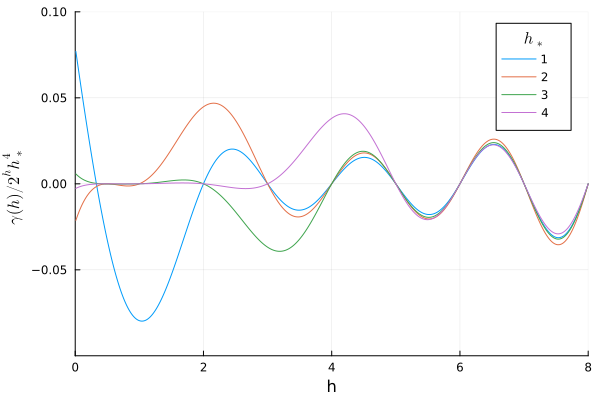

In [104]:
plot(legendtitle = L"h_*")
for hx = 1:4
    plot!(γ[!, "h"], hx^-4 .* 0.5.^γ[!, "h"] .* γ[!, string(hx)], label=hx)
end
xlims!(0,8)
ylims!(-0.1, 0.1)
xlabel!("h")
ylabel!(L"\gamma(h) / 2^h h_*^4")